A majority of the code used for this model was taken from here:
https://github.com/ritvikmath/YouTubeVideoCode/blob/main/Probability%20Calibration.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
#read in shot data. This data has been tranformed to plots shots vertically, and only contains shots on goal and goals.
shot_data = pd.read_csv('goal_probability_data.csv')

df = pd.DataFrame({'x':shot_data['x'],'y':shot_data['y'],'is_goal': (shot_data['event'] == 'Goal')})

train_frac = 0.8
test_frac = 0.2

train_X = df[['x','y']].iloc[:int(len(df) * train_frac)].values
train_y = df.is_goal.iloc[:int(len(df) * train_frac)].values

test_X = df[['x','y']].iloc[int(len(df) * train_frac):int(len(df) * (train_frac+test_frac))].values
test_y = df.is_goal.iloc[int(len(df) * train_frac):int(len(df) * (train_frac+test_frac))].values

Train Models and get Probabilities

In [3]:
model_to_clf = {
    'rf': RandomForestClassifier,
    'svc': SVC,
    'nb': GaussianNB
               }

C:\Users\ketch\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ketch\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


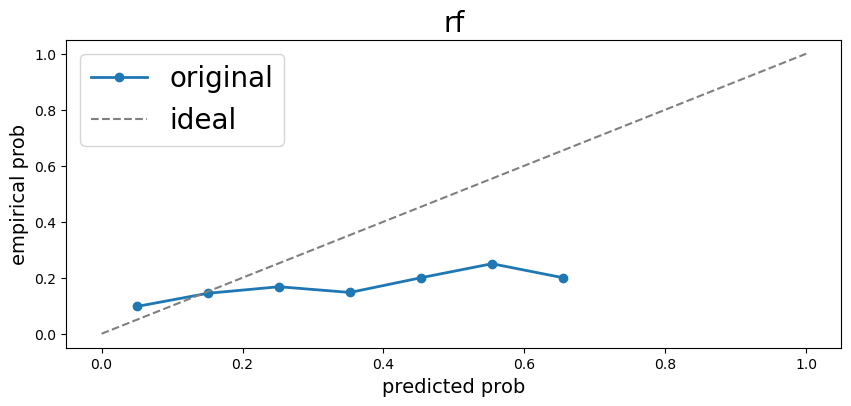

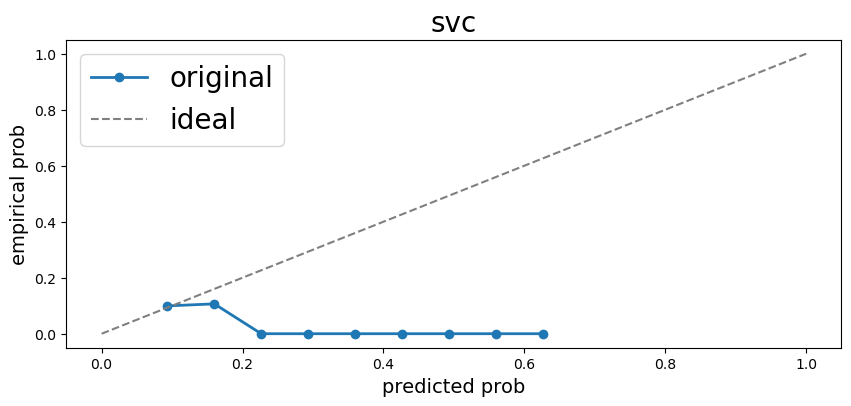

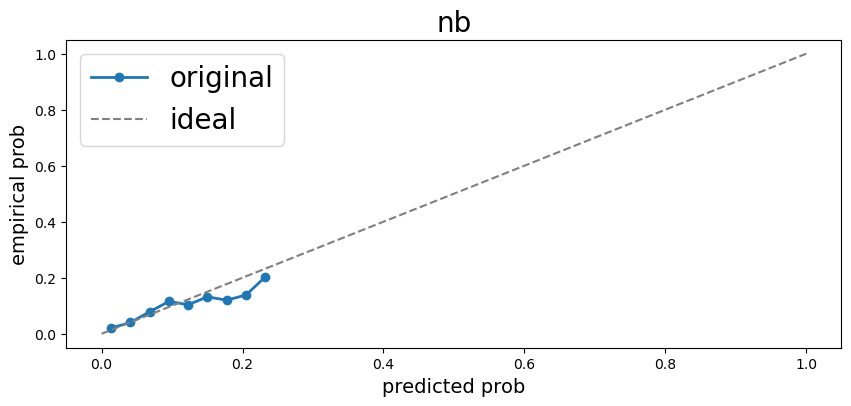

In [5]:
for model_str, pred_prob_dict in model_to_probs.items():
    pred_probs = pred_prob_dict['test']

    pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

    empirical_probs = []
    pred_probs_midpoints = []

    for i in range(len(pred_probs_space)-1):
        empirical_probs.append(np.mean(test_y[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
        pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

    plt.figure(figsize=(10,4))
    plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
    plt.title(f"{model_str}", fontsize=20)
    plt.xlabel('predicted prob', fontsize=14)
    plt.ylabel('empirical prob', fontsize=14)
    
    plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
    plt.legend(['original', 'ideal'], fontsize=20)

# **Take Best model: Naive Bayes**

In [6]:
#Get base model
clf = model_str_to_trained_model['nb']

Use model to create shot probability column (use uncalibrated)

In [7]:
shot_locations = shot_data[['x','y']].values

probs = pd.DataFrame(clf.predict_proba(shot_locations))
shot_data['shot probability'] = probs[1]
shot_data.head(10)

,Unnamed: 0.1,Unnamed: 0,x,y,event,secondaryType,shooter,blocker,team,strength,period,game_winning_goal,empty_net,goalie,game_id,assist_1,assist_2,net_distance,shot probability
0,0,0,44.0,8.0,Shot,Wrist Shot,Timo Meier,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,46.690470,0.031839
1,3,3,33.0,8.0,Shot,Slap Shot,Mattias Ekholm,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,57.558666,0.006729
2,4,4,74.0,-5.0,Goal,Wrist Shot,Kiefer Sherwood,None,Nashville Predators,Even,1,False,False,James Reimer,2022020001,Mattias Ekholm,Ryan McDonagh,16.763055,0.226578
3,5,5,81.0,15.0,Shot,Wrist Shot,Colton Sissons,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,17.492856,0.174200
4,10,10,72.0,2.0,Shot,Tip-In,Steven Lorentz,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,18.110770,0.228953
5,12,12,40.0,22.0,Shot,Snap Shot,Dante Fabbro,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,54.626001,0.008425
6,13,13,49.0,12.0,Shot,Wrist Shot,Oskar Lindblom,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,42.720019,0.047734
7,15,15,46.0,18.0,Shot,Slap Shot,Kevin Labanc,None,San Jose Sharks,None,1,NaN,NaN,Juuse Saros,2022020001,NaN,NaN,47.539457,0.024517
8,16,16,40.0,13.0,Shot,Wrist Shot,Matt Duchene,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,51.662365,0.015615
9,18,18,71.0,21.0,Shot,Wrist Shot,Eeli Tolvanen,None,Nashville Predators,None,1,NaN,NaN,James Reimer,2022020001,NaN,NaN,28.319605,0.109661


**Confirm Model: It works!**

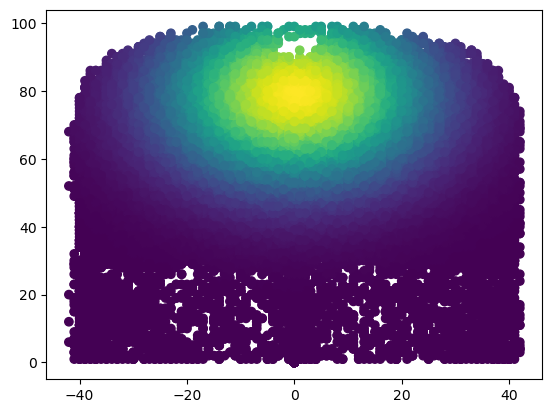

In [8]:
plt.scatter(shot_data['y'],shot_data['x'],c = shot_data['shot probability']) 

Export shots on goals csv with goal probabilities

In [9]:
shot_data.to_csv('sog_with_probabilities.csv')